In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames, default_sphere
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti

hardi_fname, hardi_bval_fname, hardi_bvec_fname = \
r"F:\Uni\master\teamproject\preprocessed\002_S_1261.nii.gz", r"F:\Uni\master\teamproject\preprocessed\002_S_1261.bval", r"F:\Uni\master\teamproject\preprocessed\002_S_1261.bvec"

data, affine = load_nifti(hardi_fname)

bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)
hardi_fname, hardi_bval_fname, hardi_bvec_fname

('F:\\Uni\\master\\teamproject\\preprocessed\\002_S_1261.nii.gz',
 'F:\\Uni\\master\\teamproject\\preprocessed\\002_S_1261.bval',
 'F:\\Uni\\master\\teamproject\\preprocessed\\002_S_1261.bvec')

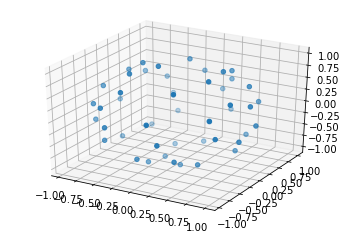

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bvecs[bvals != 0, 0], bvecs[bvals != 0, 1], bvecs[bvals != 0, 2])


In [3]:
from dipy.reconst.csdeconv import auto_response

response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)
response, ratio

((array([0.00145271, 0.00037719, 0.00037719]), 1451.111767020858),
 0.2596482821730474)

In [4]:
from dipy.viz import window, actor
from dipy.sims.voxel import single_tensor_odf

# Enables/disables interactive visualization
interactive = True

ren = window.Renderer()
evals = response[0]
evecs = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T


response_odf = single_tensor_odf(default_sphere.vertices, evals, evecs)
# transform our data from 1D to 4D
response_odf = response_odf[None, None, None, :]
response_actor = actor.odf_slicer(response_odf, sphere=default_sphere,
                                  colormap='plasma')
ren.add(response_actor)
print('Saving illustration as csd_response.png')
window.record(ren, out_path='csd_response.png', size=(200, 200))
if interactive:
    window.show(ren)

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0
  import sys


Saving illustration as csd_response.png


KeyboardInterrupt: 

In [5]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
csd_model = ConstrainedSphericalDeconvModel(gtab, response)

In [6]:
data_small = data[:, :, 38:39]
csd_fit = csd_model.fit(data_small)


In [7]:
csd_odf = csd_fit.odf(default_sphere)
csd_odf.shape

(116, 116, 1, 362)

In [8]:
fodf_spheres = actor.odf_slicer(csd_odf, sphere=default_sphere, scale=0.9,
                                norm=False, colormap='plasma')

ren.add(fodf_spheres)

print('Saving illustration as csd_odfs.png')
window.record(ren, out_path='csd_odfs.png', size=(600, 600))
if interactive:
    window.show(ren)

Saving illustration as csd_odfs.png


In [11]:
from dipy.direction import peaks_from_model

csd_peaks = peaks_from_model(model=csd_model,
                             data=data_small,
                             sphere=default_sphere,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=False)
ren.clear()
fodf_peaks = actor.peak_slicer(csd_peaks.peak_dirs, csd_peaks.peak_values)
ren.add(fodf_peaks)

print('Saving illustration as csd_peaks.png')
window.record(ren, out_path='csd_peaks.png', size=(600, 600))
if interactive:
    window.show(ren)

Saving illustration as csd_peaks.png


In [10]:
from dipy.direction import peaks_from_model

csd_peaks = peaks_from_model(model=csd_model,
                             data=data_small,
                             sphere=default_sphere,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

fodf_peaks = actor.peak_slicer(csd_peaks.peak_dirs, csd_peaks.peak_values)
ren.add(fodf_peaks)

print('Saving illustration as csd_peaks.png')
window.record(ren, out_path='csd_peaks.png', size=(600, 600))
if interactive:
    window.show(ren)

Saving illustration as csd_peaks.png


In [14]:
csd_peaks.peak_values.shape
csd_peaks.peak_dirs.shape

(116, 116, 1, 5, 3)